In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

# from matplotlib import rcParam
import seaborn as sb
import os
import sys

sys.setrecursionlimit(1000000)
from scipy.stats import spearmanr
import pathlib
import scipy as sp
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

mcc = MouseConnectivityCache()
from scipy.stats import pearsonr
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import scanpy as sc
import anndata as ad
from bg_atlasapi import BrainGlobeAtlas
from final_processing import final_processing_functions as fpf
%matplotlib inline


/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/camp/home/turnerb/.conda/envs/MAPseq_proces

In [2]:
proj_path = pathlib.Path("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq")
HVA_cols = ['VISp', 'VISpor', 'VISli', 'VISal', 'VISl', 'VISpl', 'VISpm', 'VISrl', 'VISam', 'VISa']

mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
combined_mice_dict = {}
for mouse in mice:
    new_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    parameters = fpf.load_parameters(directory=parameters_path)
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    #normalise barcodes to total sum
    barcodes = barcodes[barcodes.astype(bool).sum(axis=1)>0]

    new_dict['homog_across_cubelet'] =fpf.homog_across_cubelet(parameters_path= parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, IT_only=True)
    
    #which_mice = which_mice[combine_all_mice[HVA_cols].astype(bool).sum(axis=1)>0]
    #combine_all_mice = combine_all_mice[combine_all_mice[HVA_cols].astype(bool).sum(axis=1)>0]
    #new_dict['homog_across_cubelet'] = assigned_areas[assigned_areas.astype(bool).sum(axis=1)>2]
    #new_dict['homog_across_cubelet'] = assigned_areas[assigned_areas[HVA_cols].astype(bool).sum(axis=1)>0]
    # new_dict['homog_across_cubelet_shuffled'] =fpf.homog_across_cubelet(parameters_path= parameters_path, barcode_matrix = barcodes, cortical=False, shuffled=True, dummy_data = False)
    # new_dict['homog_across_area'] =fpf.homog_across_area(parameters_path= parameters_path, barcode_matrix = barcodes, cortical=False, shuffled=False)
    # new_dict['homog_across_area_shuffled'] =fpf.homog_across_area(parameters_path= parameters_path, barcode_matrix = barcodes, cortical=False, shuffled=True)

    combined_mice_dict[mouse] = new_dict

In [3]:
def add_prefix_to_index(df, prefix):
    df = df.copy()  # Avoid modifying the original DataFrame
    df.index = [f"{prefix}_{idx}" for idx in df.index]
    return df
index_adj_combined_dict = {}

for mouse in mice:
    index_adj_combined_dict[mouse] = add_prefix_to_index(combined_mice_dict[mouse]['homog_across_cubelet'], mouse)



In [4]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
key = 'homog_across_cubelet'
common_columns = set(combined_mice_dict['FIAA45.6a'][key].columns).intersection(
    set(combined_mice_dict['FIAA45.6d'][key].columns)
).intersection(
    set(combined_mice_dict['FIAA55.4d'][key].columns)
)
#let's make sure that all the areas are cortical (areas such as HPF are unintentially side bits of cubelets and never main target, and more likely registration errors)
common_cols_cortex = []
for col in common_columns:
    if col == 'Contra':
        common_cols_cortex.append(col)
    if col not in ['Contra', 'OB']:
        structure = structure_tree.get_structures_by_acronym([col])
        if 315 in structure[0]['structure_id_path']:
            common_cols_cortex.append(col)
combine_all_mice = pd.concat([index_adj_combined_dict['FIAA45.6a'][common_cols_cortex], index_adj_combined_dict['FIAA45.6d'][common_cols_cortex], index_adj_combined_dict['FIAA55.4d'][common_cols_cortex]])
which_mice = pd.DataFrame(columns = ['mice'], index= combine_all_mice.index)
which_mice.loc[index_adj_combined_dict['FIAA45.6a'].index] = 'FIAA45.6a'
which_mice.loc[index_adj_combined_dict['FIAA45.6d'].index] = 'FIAA45.6d'
which_mice.loc[index_adj_combined_dict['FIAA55.4d'].index] = 'FIAA55.4d'


Get AP postitions of soma

In [5]:
bg_atlas = BrainGlobeAtlas("allen_mouse_25um", check_latest=False)
AUDp_id =bg_atlas.structures['AUDp']['id']
mcc = MouseConnectivityCache(resolution=25)
rsp = mcc.get_reference_space()
AUDp_mask = rsp.make_structure_mask([AUDp_id], direct_only=False)
indices_AUDp = np.argwhere(AUDp_mask == 1)

#select anterior and posterior parts of A1
max_y = np.max(indices_AUDp[:, 0])
min_y = np.min(indices_AUDp[:, 0])
AP_midpoint_A1 = ((max_y - min_y) /2) + min_y
posterior_neurons = indices_AUDp[indices_AUDp[:, 0]>=AP_midpoint_A1]
anterior_neurons = indices_AUDp[indices_AUDp[:, 0]<AP_midpoint_A1]
#now select only the ipsiliateral side of where was injected
x_midpoint = AUDp_mask.shape[2] // 2
contra_mask = np.zeros_like(AUDp_mask, dtype=bool)
contra_mask[:, :, x_midpoint:] = 1


#now lets load the barcodes
proj_path = pathlib.Path("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq")
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
mouse_dict_AP_source = {}
mouse_barcodes_by_source = {}
for mouse in mice:
    #if mouse == 'FIAA45.6d':
    AP_position_dict = {}
    barcodes = pd.read_pickle(f"{proj_path}/{mouse}/Sequencing/A1_barcodes_thresholded_with_source.pkl")
    #indices = which_mice[which_mice['mice'] == mouse].index
    #barcodes = barcodes.loc[indices]
    lcm_directory = proj_path/f"{mouse}/LCM"
    ROI_3D = np.load(lcm_directory / "ROI_3D_25.npy")
    AP_samples = {}
    AP_source_filtered = {}
    all_AUDp_samples = np.unique(ROI_3D *  AUDp_mask * contra_mask)
    all_AUDp_samples = [sample for sample in all_AUDp_samples if sample != 0]
    all_AUDp_samples = [sample for sample in all_AUDp_samples if sample in barcodes.columns]
    for sample in all_AUDp_samples:
        centroid = np.argwhere(ROI_3D == sample).mean(axis=0)
        AP_position_dict[sample] = centroid[0]-AP_midpoint_A1
    mouse_dict_AP_source[mouse]=AP_position_dict

In [6]:
#get list of sources from each barcode, then create a dictionary
soma = pd.DataFrame(barcodes.idxmax(axis=1))
def get_AP_position(row, dictionary):
    key = row[0]
    if key in dictionary.keys():
        return dictionary[key]
    else:
        return None  # or any other default value you want to use if the key is not found

barcodes_dict = {}
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
AP_position_dict_list = {}
for mouse in mice:
    new_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded_with_source.pkl")
    barcodes= add_prefix_to_index(barcodes, mouse)
    #barcodes_assigned_area =fpf.area_is_main(parameters_path= parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, IT_only=True)
    #barcodes_assigned_area = barcodes_assigned_area[barcodes_assigned_area.astype(bool).sum(axis=1)>2]#increased as now AUDp is here
    
    #barcodes = barcodes.loc[barcodes_assigned_area.index.to_list()]
    soma = pd.DataFrame(barcodes.idxmax(axis=1))
    soma['AP_position'] = soma.apply(lambda row: get_AP_position(row, mouse_dict_AP_source[mouse]), axis=1)
    #barcodes_dict[mouse] = barcodes_assigned_area.drop(columns=['AUDp'])
    #soma_filtered = soma.loc[combined_mice_dict[mouse]['homog_across_cubelet'].index]
    AP_position_dict_list[mouse] = soma#soma_filtered
AP_position_dict_list_combined= pd.concat([AP_position_dict_list['FIAA45.6a'], AP_position_dict_list['FIAA45.6d'], AP_position_dict_list['FIAA55.4d']])

In [7]:
area_correlations =pd.DataFrame()
for area in combine_all_mice.columns:
    ap_positions = AP_position_dict_list_combined.loc[combine_all_mice.index]['AP_position']
    area_correlations.loc['corr_all_mice', area] = combine_all_mice[area].astype(bool).astype(int).corr(ap_positions, method='spearman')
    for mouse in mice:
        mouse_ind = which_mice[which_mice['mice']==mouse].index
        ap_corr_mouse = AP_position_dict_list_combined.loc[mouse_ind]['AP_position']
        mouse_bcs = combine_all_mice.loc[mouse_ind].astype(bool).astype(int)
        area_correlations.loc[f'{mouse}', area] = mouse_bcs[area].corr(ap_corr_mouse, method='spearman')
        

In [ ]:
area_correlations =pd.DataFrame()
for area in combine_all_mice.columns:
    ap_positions = AP_position_dict_list_combined.loc[combine_all_mice.index]['AP_position']
    #area_correlations.loc['corr_all_mice', area] = combine_all_mice[area].astype(bool).astype(int).corr(ap_positions, method='spearman')
    for mouse in mice:
        mouse_ind = which_mice[which_mice['mice']==mouse].index
        ap_corr_mouse = AP_position_dict_list_combined.loc[mouse_ind]['AP_position']
        mouse_bcs = combine_all_mice.loc[mouse_ind].astype(bool).astype(int)
        area_correlations.loc[f'{mouse}', area] = mouse_bcs[area].corr(ap_corr_mouse, method='spearman')
        

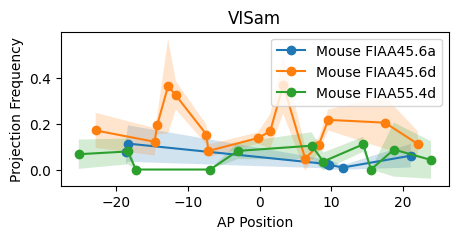

In [56]:
#for each mouse, plot frequency of targeting for each AP position
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sem

# Sample DataFrames and Data
# which_mice, AP_position_dict_list_combined, combine_all_mice should be pre-defined as in your context.

plt.figure(figsize=(5, 2))
area = 'VISam'
# Loop through each mouse to create a line on the plot
for mouse in mice:
    # Get the indices for the current mouse
    mouse_ind = which_mice[which_mice['mice'] == mouse].index
    
    # Get the AP positions and 'TEa' projection frequency for each mouse
    ap_positions = np.unique(AP_position_dict_list_combined.loc[mouse_ind]['AP_position'])
    projection_freqs = combine_all_mice.loc[mouse_ind].astype(bool).astype(int)[area]
    
    # Aggregate the data for each AP position (mean and confidence interval)
    mean_projection_freqs = []
    ci_projection_freqs = []

    for ap in ap_positions:
        # Select the projection frequencies corresponding to the current AP position
        ap_proj_freqs = projection_freqs[AP_position_dict_list_combined.loc[mouse_ind]['AP_position'] == ap]
        
        # Calculate the mean and 95% confidence interval
        mean_proj = ap_proj_freqs.mean()
        ci_proj = sem(ap_proj_freqs) * 1.96  # 1.96 for 95% CI

        mean_projection_freqs.append(mean_proj)
        ci_projection_freqs.append(ci_proj)

    # Plot the mean line and confidence interval as a shaded region for the current mouse
    plt.plot(ap_positions, mean_projection_freqs, label=f'Mouse {mouse}', marker='o')
    plt.fill_between(ap_positions, 
                     np.array(mean_projection_freqs) - np.array(ci_projection_freqs),
                     np.array(mean_projection_freqs) + np.array(ci_projection_freqs),
                     alpha=0.2)

# Plot customization
plt.xlabel("AP Position")
plt.ylabel("Projection Frequency")
plt.title(f"{area}")
plt.legend()
plt.show()


No handles with labels found to put in legend.


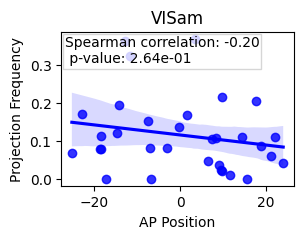

In [57]:

from scipy.stats import sem, spearmanr

area='VISam'
# Initialize dictionaries to store all projection frequencies for each AP position across all mice
ap_position_data = {}

# Loop through each mouse and gather projection frequency data by AP position
for mouse in mice:
    # Get the indices for the current mouse
    mouse_ind = which_mice[which_mice['mice'] == mouse].index
    
    # Get the AP positions and 'TEa' projection frequency for each mouse
    ap_positions = AP_position_dict_list_combined.loc[mouse_ind]['AP_position']
    projection_freqs = combine_all_mice.loc[mouse_ind].astype(bool).astype(int)[area]
    
    # Combine data for each AP position across all mice
    for ap, freq in zip(ap_positions, projection_freqs):
        if ap not in ap_position_data:
            ap_position_data[ap] = []
        ap_position_data[ap].append(freq)

# Calculate mean and confidence interval for each AP position across all mice
ap_positions_sorted = sorted(ap_position_data.keys())
mean_projection_freqs = []
ci_projection_freqs = []

for ap in ap_positions_sorted:
    # Get all projection frequencies for this AP position across all mice
    ap_proj_freqs = np.array(ap_position_data[ap])
    
    # Calculate the mean and 95% confidence interval
    mean_proj = ap_proj_freqs.mean()
    ci_proj = sem(ap_proj_freqs) * 1.96  # 1.96 for 95% CI
    
    mean_projection_freqs.append(mean_proj)
    ci_projection_freqs.append(ci_proj)

# Calculate Spearman correlation
spearman_corr, p_value = spearmanr(ap_positions_sorted, mean_projection_freqs)

# Plot the mean projection frequencies with confidence intervals
plt.figure(figsize=(3, 2))
sb.regplot(x=ap_positions_sorted, y=mean_projection_freqs, color="blue", marker='o')
# plt.fill_between(ap_positions_sorted, 
#                  np.array(mean_projection_freqs) - np.array(ci_projection_freqs),
#                  np.array(mean_projection_freqs) + np.array(ci_projection_freqs),
#                  alpha=0.2, label="95% Confidence Interval")

# Display the Spearman correlation and p-value in the plot legend
plt.legend(title=f"Spearman correlation: {spearman_corr:.2f}\n p-value: {p_value:.2e}", loc='upper left', fontsize =3)

# Plot customization
plt.xlabel("AP Position")
plt.ylabel("Projection Frequency")
plt.title(f"{area}")
plt.show()


No handles with labels found to put in legend.


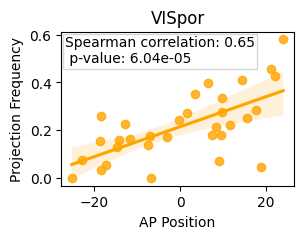

In [35]:

from scipy.stats import sem, spearmanr

area='VISpor'
# Initialize dictionaries to store all projection frequencies for each AP position across all mice
ap_position_data = {}

# Loop through each mouse and gather projection frequency data by AP position
for mouse in mice:
    # Get the indices for the current mouse
    mouse_ind = which_mice[which_mice['mice'] == mouse].index
    
    # Get the AP positions and 'TEa' projection frequency for each mouse
    ap_positions = AP_position_dict_list_combined.loc[mouse_ind]['AP_position']
    projection_freqs = combine_all_mice.loc[mouse_ind].astype(bool).astype(int)[area]
    
    # Combine data for each AP position across all mice
    for ap, freq in zip(ap_positions, projection_freqs):
        if ap not in ap_position_data:
            ap_position_data[ap] = []
        ap_position_data[ap].append(freq)

# Calculate mean and confidence interval for each AP position across all mice
ap_positions_sorted = sorted(ap_position_data.keys())
mean_projection_freqs = []
ci_projection_freqs = []

for ap in ap_positions_sorted:
    # Get all projection frequencies for this AP position across all mice
    ap_proj_freqs = np.array(ap_position_data[ap])
    
    # Calculate the mean and 95% confidence interval
    mean_proj = ap_proj_freqs.mean()
    ci_proj = sem(ap_proj_freqs) * 1.96  # 1.96 for 95% CI
    
    mean_projection_freqs.append(mean_proj)
    ci_projection_freqs.append(ci_proj)

# Calculate Spearman correlation
spearman_corr, p_value = spearmanr(ap_positions_sorted, mean_projection_freqs)

# Plot the mean projection frequencies with confidence intervals
plt.figure(figsize=(3, 2))
sb.regplot(x=ap_positions_sorted, y=mean_projection_freqs, color="orange", marker='o')
# plt.fill_between(ap_positions_sorted, 
#                  np.array(mean_projection_freqs) - np.array(ci_projection_freqs),
#                  np.array(mean_projection_freqs) + np.array(ci_projection_freqs),
#                  alpha=0.2, label="95% Confidence Interval")

# Display the Spearman correlation and p-value in the plot legend
plt.legend(title=f"Spearman correlation: {spearman_corr:.2f}\n p-value: {p_value:.2e}", loc='upper left', fontsize =3)

# Plot customization
plt.xlabel("AP Position")
plt.ylabel("Projection Frequency")
plt.title(f"{area}")
plt.show()


No handles with labels found to put in legend.


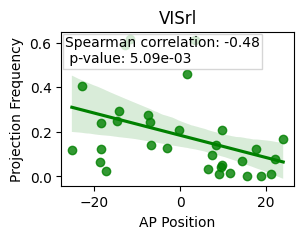

In [44]:

from scipy.stats import sem, spearmanr

area='VISrl'
# Initialize dictionaries to store all projection frequencies for each AP position across all mice
ap_position_data = {}

# Loop through each mouse and gather projection frequency data by AP position
for mouse in mice:
    # Get the indices for the current mouse
    mouse_ind = which_mice[which_mice['mice'] == mouse].index
    
    # Get the AP positions and 'TEa' projection frequency for each mouse
    ap_positions = AP_position_dict_list_combined.loc[mouse_ind]['AP_position']
    projection_freqs = combine_all_mice.loc[mouse_ind].astype(bool).astype(int)[area]
    
    # Combine data for each AP position across all mice
    for ap, freq in zip(ap_positions, projection_freqs):
        if ap not in ap_position_data:
            ap_position_data[ap] = []
        ap_position_data[ap].append(freq)

# Calculate mean and confidence interval for each AP position across all mice
ap_positions_sorted = sorted(ap_position_data.keys())
mean_projection_freqs = []
ci_projection_freqs = []

for ap in ap_positions_sorted:
    # Get all projection frequencies for this AP position across all mice
    ap_proj_freqs = np.array(ap_position_data[ap])
    
    # Calculate the mean and 95% confidence interval
    mean_proj = ap_proj_freqs.mean()
    ci_proj = sem(ap_proj_freqs) * 1.96  # 1.96 for 95% CI
    
    mean_projection_freqs.append(mean_proj)
    ci_projection_freqs.append(ci_proj)

# Calculate Spearman correlation
spearman_corr, p_value = spearmanr(ap_positions_sorted, mean_projection_freqs)

# Plot the mean projection frequencies with confidence intervals
plt.figure(figsize=(3, 2))
sb.regplot(x=ap_positions_sorted, y=mean_projection_freqs, color="green", marker='o')
# plt.fill_between(ap_positions_sorted, 
#                  np.array(mean_projection_freqs) - np.array(ci_projection_freqs),
#                  np.array(mean_projection_freqs) + np.array(ci_projection_freqs),
#                  alpha=0.2, label="95% Confidence Interval")

# Display the Spearman correlation and p-value in the plot legend
plt.legend(title=f"Spearman correlation: {spearman_corr:.2f}\n p-value: {p_value:.2e}", loc='upper left', fontsize =3)

# Plot customization
plt.xlabel("AP Position")
plt.ylabel("Projection Frequency")
plt.title(f"{area}")
plt.show()


No handles with labels found to put in legend.


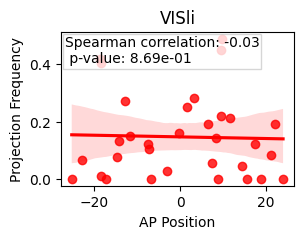

In [48]:

from scipy.stats import sem, spearmanr

area='VISli'
# Initialize dictionaries to store all projection frequencies for each AP position across all mice
ap_position_data = {}

# Loop through each mouse and gather projection frequency data by AP position
for mouse in mice:
    # Get the indices for the current mouse
    mouse_ind = which_mice[which_mice['mice'] == mouse].index
    
    # Get the AP positions and 'TEa' projection frequency for each mouse
    ap_positions = AP_position_dict_list_combined.loc[mouse_ind]['AP_position']
    projection_freqs = combine_all_mice.loc[mouse_ind].astype(bool).astype(int)[area]
    
    # Combine data for each AP position across all mice
    for ap, freq in zip(ap_positions, projection_freqs):
        if ap not in ap_position_data:
            ap_position_data[ap] = []
        ap_position_data[ap].append(freq)

# Calculate mean and confidence interval for each AP position across all mice
ap_positions_sorted = sorted(ap_position_data.keys())
mean_projection_freqs = []
ci_projection_freqs = []

for ap in ap_positions_sorted:
    # Get all projection frequencies for this AP position across all mice
    ap_proj_freqs = np.array(ap_position_data[ap])
    
    # Calculate the mean and 95% confidence interval
    mean_proj = ap_proj_freqs.mean()
    ci_proj = sem(ap_proj_freqs) * 1.96  # 1.96 for 95% CI
    
    mean_projection_freqs.append(mean_proj)
    ci_projection_freqs.append(ci_proj)

# Calculate Spearman correlation
spearman_corr, p_value = spearmanr(ap_positions_sorted, mean_projection_freqs)

# Plot the mean projection frequencies with confidence intervals
plt.figure(figsize=(3, 2))
sb.regplot(x=ap_positions_sorted, y=mean_projection_freqs, color="red", marker='o')
# plt.fill_between(ap_positions_sorted, 
#                  np.array(mean_projection_freqs) - np.array(ci_projection_freqs),
#                  np.array(mean_projection_freqs) + np.array(ci_projection_freqs),
#                  alpha=0.2, label="95% Confidence Interval")

# Display the Spearman correlation and p-value in the plot legend
plt.legend(title=f"Spearman correlation: {spearman_corr:.2f}\n p-value: {p_value:.2e}", loc='upper left', fontsize =3)

# Plot customization
plt.xlabel("AP Position")
plt.ylabel("Projection Frequency")
plt.title(f"{area}")
plt.show()


No handles with labels found to put in legend.


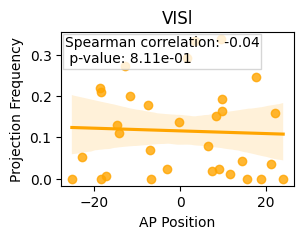

In [41]:
from scipy.stats import sem, pearsonr

area='VISl'
# Initialize dictionaries to store all projection frequencies for each AP position across all mice
ap_position_data = {}

# Loop through each mouse and gather projection frequency data by AP position
for mouse in mice:
    # Get the indices for the current mouse
    mouse_ind = which_mice[which_mice['mice'] == mouse].index
    
    # Get the AP positions and 'TEa' projection frequency for each mouse
    ap_positions = AP_position_dict_list_combined.loc[mouse_ind]['AP_position']
    projection_freqs = combine_all_mice.loc[mouse_ind].astype(bool).astype(int)[area]
    
    # Combine data for each AP position across all mice
    for ap, freq in zip(ap_positions, projection_freqs):
        if ap not in ap_position_data:
            ap_position_data[ap] = []
        ap_position_data[ap].append(freq)

# Calculate mean and confidence interval for each AP position across all mice
ap_positions_sorted = sorted(ap_position_data.keys())
mean_projection_freqs = []
ci_projection_freqs = []

for ap in ap_positions_sorted:
    # Get all projection frequencies for this AP position across all mice
    ap_proj_freqs = np.array(ap_position_data[ap])
    
    # Calculate the mean and 95% confidence interval
    mean_proj = ap_proj_freqs.mean()
    ci_proj = sem(ap_proj_freqs) * 1.96  # 1.96 for 95% CI
    
    mean_projection_freqs.append(mean_proj)
    ci_projection_freqs.append(ci_proj)

# Calculate Spearman correlation
#spearman_corr, p_value = spearmanr(ap_positions_sorted, mean_projection_freqs)
pearson_corr, p_value = pearsonr(ap_positions_sorted, mean_projection_freqs)
# Plot the mean projection frequencies with confidence intervals
plt.figure(figsize=(3, 2))
sb.regplot(x=ap_positions_sorted, y=mean_projection_freqs, color="orange", marker='o')
# plt.fill_between(ap_positions_sorted, 
#                  np.array(mean_projection_freqs) - np.array(ci_projection_freqs),
#                  np.array(mean_projection_freqs) + np.array(ci_projection_freqs),
#                  alpha=0.2, label="95% Confidence Interval")

# Display the Spearman correlation and p-value in the plot legend
plt.legend(title=f"Spearman correlation: {pearson_corr:.2f}\n p-value: {p_value:.2e}", loc='upper left', fontsize =3)

# Plot customization
plt.xlabel("AP Position")
plt.ylabel("Projection Frequency")
plt.title(f"{area}")
plt.show()

In [17]:
area_correlations

,SSp,SSs,VISam,VISpor,VISp,MOs,RSPagl,VISa,Contra,AUDpo,MOp,RSPd,ACAv,TEa,VISrl,VISpm,VISl,AUDv,AUDd
corr_all_mice,-0.147808,-0.171107,-0.034408,0.226471,-0.001492,-0.026617,0.043939,-0.118452,-0.033486,-0.155023,-0.066800,-0.003420,-0.012512,0.142381,-0.154271,-0.036596,-0.017180,-0.065423,-0.011302
FIAA45.6a,-0.179207,-0.216560,-0.021759,0.153568,-0.109013,-0.069677,-0.048500,-0.117121,-0.078783,-0.292093,-0.061582,0.031692,-0.062102,0.100305,-0.073763,-0.055661,0.056766,0.136195,0.045397
FIAA45.6d,-0.155162,-0.203780,-0.003946,0.179103,0.046906,-0.072208,0.026161,-0.113235,0.098075,-0.095341,-0.058005,0.059214,-0.052920,0.155414,-0.165641,-0.029800,0.065617,-0.134491,-0.003006
FIAA55.4d,-0.079416,-0.156092,0.062655,0.353874,0.118407,0.041598,0.078966,0.030851,-0.185075,0.188054,-0.056796,-0.018046,0.031946,0.247709,-0.054045,0.106201,0.030769,-0.038740,-0.123364


In [15]:
area_correlations

,SSp,SSs,VISam,VISpor,VISp,MOs,RSPagl,VISa,Contra,AUDpo,MOp,RSPd,ACAv,TEa,VISrl,VISpm,VISl,AUDv,AUDd
corr_all_mice,-0.152733,-0.174956,-0.032774,0.242806,0.003141,-0.026654,0.044053,-0.121095,-0.073412,-0.135552,-0.066878,-0.003234,-0.012358,0.202206,-0.155536,-0.035821,-0.015984,-0.063254,0.000582
FIAA45.6a,-0.181084,-0.223389,-0.021792,0.163470,-0.108706,-0.069672,-0.048637,-0.117319,-0.118919,-0.287345,-0.061496,0.031809,-0.062053,0.078964,-0.074197,-0.055608,0.056766,0.249930,0.000750
FIAA45.6d,-0.162047,-0.209965,-0.001647,0.184871,0.053088,-0.072952,0.026307,-0.118726,0.057457,-0.115500,-0.058637,0.058556,-0.052905,0.223346,-0.170845,-0.030694,0.067110,-0.143913,0.034594
FIAA55.4d,-0.088335,-0.163372,0.062824,0.360749,0.119173,0.042760,0.079334,0.032317,-0.243024,0.185903,-0.056662,-0.018027,0.031996,0.347297,-0.055371,0.105834,0.030751,-0.116084,-0.124041
